In [39]:
import pandas as pd

In [40]:
# # Step 1: Read the original CSV
# df = pd.read_csv('Forestry_Trade_Flows_All_Data/Forestry_Trade_Flows_E_All_Data.csv', encoding='ISO-8859-1')
# print(len(df))
# # Step 2: Split the DataFrame into two halves
# split_index = len(df) // 2
# df1 = df.iloc[:split_index]
# df2 = df.iloc[split_index:]

# # Step 3: Save each part to a separate CSV file
# df1.to_csv('Forestry_Trade_Flows_All_Data/Forestry_Trade_Flows_E_All_Data_1.csv', index=False)
# df2.to_csv('Forestry_Trade_Flows_All_Data/Forestry_Trade_Flows_E_All_Data_2.csv', index=False)

# Step 4: Read the two CSV files


In [41]:
import pandas as pd
def current_network_study():
    df1 = pd.read_csv('Forestry_Trade_Flows_All_Data/Forestry_Trade_Flows_E_All_Data_1.csv', encoding='ISO-8859-1')
    df2 = pd.read_csv('Forestry_Trade_Flows_All_Data/Forestry_Trade_Flows_E_All_Data_2.csv', encoding='ISO-8859-1')
    # Step 5: Concatenate the two DataFrames
    #df = pd.read_csv('Forestry_Trade_Flows_All_Data/Forestry_Trade_Flows_E_All_Data.csv', encoding='ISO-8859-1')
    df = pd.concat([df1, df2])
    print(len(df))
    # >10% possible links
    df.rename(columns={'Reporter Countries': 'Source', 'Partner Countries': 'Target'}, inplace=True)
    
    # Get nodes
    country_df = df.drop_duplicates(subset=['Source'])
    dict = {item: count for count, item in enumerate(country_df['Source'])}
    country_df['Id'] = country_df['Source'].apply(lambda x: dict.get(x, -1))
    country_df[['Id', 'Source']].to_csv('current_network_study/country_list.csv', index=False)
    country_list = country_df['Source']

    # Filter for Year 2018 and non-null values
    filtered_df = df[(df['Item'] == 'Forest products (export/import)') & (df['Element'] == 'Export Value') & (df['Item'] == 'Forest products (export/import)') & (df['Target'] != 'Total FAO') & (df['Target'] != 'Others (adjustment)') & (df['Target'] != 'Unspecified Area') & (df['Y2018'].notna())]
    #filtered_df['Y2018'] = pd.to_numeric(filtered_df['Y2018'], errors='coerce')
    sorted_df = filtered_df.sort_values(by='Y2018', ascending=False)
    sorted_df = sorted_df[['Source', 'Target']]
    sorted_df['Source'] = sorted_df['Source'].replace(dict)
    sorted_df['Target'] = sorted_df['Target'].replace(dict)

    maximum_edge = len(df['Source'].unique())
    maximum_num_edge = maximum_edge * (maximum_edge-1)
    density = len(filtered_df) / maximum_num_edge

    # Different Thresholds
    print(len(sorted_df))
    fifteen_percent = int(0.15*maximum_num_edge)
    ten_percent = int(0.1*maximum_num_edge)
    five_percent = int(0.05*maximum_num_edge)

    fifteen_df = sorted_df.head(fifteen_percent)
    ten_df = sorted_df.head(ten_percent)
    five_df = sorted_df.head(five_percent)
    
    fifteen_unique = len(pd.unique(fifteen_df[['Source', 'Target']].values.ravel()))
    ten_unique = len(pd.unique(ten_df[['Source', 'Target']].values.ravel()))
    five_unique = len(pd.unique(five_df[['Source', 'Target']].values.ravel()))
    print(fifteen_unique, ten_unique, five_unique)
    print(density, fifteen_percent, ten_percent, five_percent)
    
    fifteen_df.to_csv('current_network_study/fifteen_percent.csv', index=False)
    ten_df.to_csv('current_network_study/ten_percent.csv', index=False)
    five_df.to_csv('current_network_study/five_percent.csv', index=False)
    
    # Total FAO
current_network_study()

333646
8380
166 163 139
0.28162387417663665 4463 2975 1487


/var/folders/h5/5nz0lxy96xxbngwn5250d00h0000gn/T/ipykernel_16555/264711017.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_df['Id'] = country_df['Source'].apply(lambda x: dict.get(x, -1))
/var/folders/h5/5nz0lxy96xxbngwn5250d00h0000gn/T/ipykernel_16555/264711017.py:24: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sorted_df['Source'] = sorted_df['Source'].replace(dict)
/var/folders/h5/5nz0lxy96xxbngwn5250d00h0000gn/T/ipykernel_16555/264711017.py:25: FutureWarning: Downcasting behavior in `replace` is depre

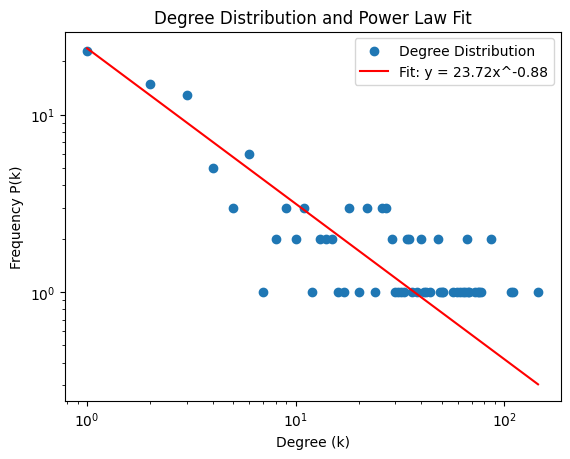

Estimated Power Law Exponent: 0.88


In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Sample DataFrame (replace this with your data)
data = pd.read_csv('current_network_study/five_percent.csv', encoding='ISO-8859-1')
df = pd.DataFrame(data)

# Step 1: Calculate node degree
degree_df = pd.concat([df['Source'], df['Target']])
degree_counts = degree_df.value_counts().reset_index()
degree_counts.columns = ['Node', 'Degree']


# Step 2: Degree distribution
degree_dist = degree_counts['Degree'].value_counts().sort_index()

# Step 3: Fit to power law
def power_law(x, a, b):
    return a * np.power(x, -b)

x_data = degree_dist.index
y_data = degree_dist.values

# Log transform for linear fitting
log_x = np.log(x_data)
log_y = np.log(y_data)

params, _ = curve_fit(power_law, x_data, y_data)
a, b = params

# Plotting the degree distribution and fitted curve
plt.figure()
plt.scatter(x_data, y_data, label='Degree Distribution')
plt.plot(x_data, power_law(x_data, *params), color='red', label=f'Fit: y = {a:.2f}x^-{b:.2f}')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Degree (k)')
plt.ylabel('Frequency P(k)')
plt.legend()
plt.title('Degree Distribution and Power Law Fit')
plt.show()

print(f"Estimated Power Law Exponent: {b:.2f}")


In [43]:
# Convert the data to a DataFrame and sort by 'Degree'
df_new = pd.read_csv('current_network_study/5.csv', encoding='ISO-8859-1')

# closnesscentrality
# betweenesscentrality
# pageranks
# Sort by 'Degree' and get the top 5
df_sorted = df_new.sort_values(by='pageranks', ascending=False).head(5)

print(df_sorted)


      Id                     Label                    source  \
24    33                     China                     China   
55    73                     India                     India   
106  133              Saudi Arabia              Saudi Arabia   
132  164  United States of America  United States of America   
125  157                  TÃ¼rkiye                  TÃ¼rkiye   

     modularity_class  indegree  outdegree  Degree  Eccentricity  \
24                 24        72         73     145             3   
55                 16        41         18      59             4   
106                16        29          6      35             4   
132                 4        44         66     110             3   
125                 4        35         22      57             4   

     closnesscentrality  harmonicclosnesscentrality  betweenesscentrality  \
24             0.696133                    0.787037           4272.425425   
55             0.480916                    0.535053 